In [1]:
import sys
import os

# Add the path to the directory containing your module
sys.path.append(os.path.abspath('/projectnb/textconv/dgwave/AudioSCC/data'))
sys.path.append(os.path.abspath('/projectnb/textconv/dgwave/AudioSCC/losses'))
sys.path.append(os.path.abspath('/projectnb/textconv/dgwave/AudioSCC/models'))

In [2]:
from dataloader import WaveformDatasetPreload
from sampler import RandomConsecutiveSampler
from losses import ConsecutiveDifferenceHigherOrderLossBatch, ConsecutiveDifferenceHigherOrderLoss
from SwissArmyModel import SeqModel


import numpy as np
import torch
from tqdm import tqdm 
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

In [3]:
# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the first available GPU
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU found, using CPU.")

Using GPU: Tesla V100-SXM2-16GB


In [4]:
def generate_sine_tensor(num_bits, length):
    # Create an array of integers from 0 to length - 1
    t = np.arange(length)
    # Generate the sine waves for each bit
    sine_tensor = np.zeros((length, num_bits))  # Initialize the tensor
    
    for i in range(num_bits):
        frequency = (np.pi / (2 ** i))  # Calculate frequency based on the number of bits
        sine_tensor[:, i] = np.cos(frequency * (t))  # Fill the tensor with sine values

    return sine_tensor

In [5]:
num_bits = 30
max_len = 50_000
seq_bits = 20
seq_max_len = 3
directory = "/projectnb/textconv/dgwave/AudioSCC/data/digits_two/"
terminal_pad = 11
seq_vocab_len = 10

# Sampler setup as before
batch_size = 200
consecutive_size = 40

In [6]:
t_input = torch.tensor(generate_sine_tensor(num_bits,max_len)).float()
print(t_input.shape)

seq_t = torch.tensor(generate_sine_tensor(seq_bits,seq_max_len)).float()
print(seq_t.shape)

torch.Size([50000, 30])
torch.Size([3, 20])


In [7]:
t_input

tensor([[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
          1.0000e+00,  1.0000e+00],
        [-1.0000e+00,  6.1232e-17,  7.0711e-01,  ...,  1.0000e+00,
          1.0000e+00,  1.0000e+00],
        [ 1.0000e+00, -1.0000e+00,  6.1232e-17,  ...,  1.0000e+00,
          1.0000e+00,  1.0000e+00],
        ...,
        [-1.0000e+00,  8.0013e-13, -7.0711e-01,  ...,  1.0000e+00,
          1.0000e+00,  1.0000e+00],
        [ 1.0000e+00, -1.0000e+00, -1.6817e-12,  ...,  1.0000e+00,
          1.0000e+00,  1.0000e+00],
        [-1.0000e+00, -5.9268e-12,  7.0711e-01,  ...,  1.0000e+00,
          1.0000e+00,  1.0000e+00]])

In [8]:
seq_t

tensor([[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
          1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
          1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
          1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00],
        [-1.0000e+00,  6.1232e-17,  7.0711e-01,  9.2388e-01,  9.8079e-01,
          9.9518e-01,  9.9880e-01,  9.9970e-01,  9.9992e-01,  9.9998e-01,
          1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
          1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00],
        [ 1.0000e+00, -1.0000e+00,  6.1232e-17,  7.0711e-01,  9.2388e-01,
          9.8079e-01,  9.9518e-01,  9.9880e-01,  9.9970e-01,  9.9992e-01,
          9.9998e-01,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
          1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00]])

In [9]:
dataset = WaveformDatasetPreload(directory, t_input, max_len, terminal_pad, seq_vocab_len, seq_max_len, seq_t)

 


sampler = RandomConsecutiveSampler(dataset, batch_size, consecutive_size)

# DataLoader
dataloader = DataLoader(dataset, batch_sampler=sampler, num_workers=4)

In [10]:
iteration = 0

for batch in dataloader:
    wav_data, t_step, target, file_idx, seq_inputs = batch #right now this wraps arround, just fyi.  not sure its a bad thing.

    print("Waveform data:", wav_data.shape)
    print("Time step:", t_step.shape)
    print("Target tensor:", target.shape)
    print("File index:", file_idx.shape)
    print("File index:", seq_inputs.shape)

    #print(wav_data)
    #print(prev_target)
    iteration = iteration + 1
    if iteration > 10:
        break
    

Waveform data: torch.Size([8000, 1])
Time step: torch.Size([8000, 30])
Target tensor: torch.Size([8000, 1])
File index: torch.Size([8000, 3])
File index: torch.Size([8000, 3, 20])
Waveform data: torch.Size([8000, 1])
Time step: torch.Size([8000, 30])
Target tensor: torch.Size([8000, 1])
File index: torch.Size([8000, 3])
File index: torch.Size([8000, 3, 20])
Waveform data: torch.Size([8000, 1])
Time step: torch.Size([8000, 30])
Target tensor: torch.Size([8000, 1])
File index: torch.Size([8000, 3])
File index: torch.Size([8000, 3, 20])
Waveform data: torch.Size([8000, 1])
Time step: torch.Size([8000, 30])
Target tensor: torch.Size([8000, 1])
File index: torch.Size([8000, 3])
File index: torch.Size([8000, 3, 20])
Waveform data: torch.Size([8000, 1])
Time step: torch.Size([8000, 30])
Target tensor: torch.Size([8000, 1])
File index: torch.Size([8000, 3])
File index: torch.Size([8000, 3, 20])
Waveform data: torch.Size([8000, 1])
Time step: torch.Size([8000, 30])
Target tensor: torch.Size([80

In [11]:

config = {
    't_seq_bits': seq_bits,  # Example value for the input bit size
    't_seq_len': seq_max_len,    # Example value for the sequence length
    't_bits': num_bits,      # Example value for the bits used in the decoder

    'encoder': {
        't_layer_dim': 0,               # Example hidden layer dimension for encoder
        't_num_layers': 0,                # Example number of layers in the encoder's initial layer
        'fc_layers': 5,                   # Example number of fully connected layers in the encoder
        'encoder_layers': 2,              # Example number of encoder layers
        'one_hot_vocab_len': 10,          # Vocabulary size for one-hot encoding
        'one_hot_embedding_dim': 100       # Embedding dimension for one-hot encoding
    },

    'decoder': {
        't_layer_dim': 0,                # Example hidden layer dimension for decoder
        't_num_layers': 0,                # Example number of layers in the decoder's initial layer
        'fc_layers': 5,                   # Example number of fully connected layers in the decoder
        'decoder_layers': 2
    },

    'output': {
        'mse_output_layers': 4,           # Number of layers in the MSE output head
        'mse_dim': 64,                     # Hidden dimension for the MSE output head
        'bce_output_layers': 4,            # Number of layers in the BCE output head
        'bce_dim': 64                      # Hidden dimension for the BCE output head
    }
}


In [12]:
model = SeqModel(config)

In [13]:
model.to(device)

SeqModel(
  (encoder): SeqEncoder(
    (initial_layer): SwissArmyLayer(
      (t_layers): ModuleList()
      (embedding): Embedding(11, 100, padding_idx=10)
      (layers): ModuleList(
        (0): Linear(in_features=120, out_features=120, bias=True)
        (1): Linear(in_features=120, out_features=120, bias=True)
        (2): Linear(in_features=120, out_features=120, bias=True)
        (3): Linear(in_features=120, out_features=120, bias=True)
        (4): Linear(in_features=120, out_features=120, bias=True)
      )
    )
    (encoder_layers): ModuleList(
      (0): SwissArmyLayer(
        (t_layers): ModuleList()
        (embedding): Embedding(11, 100, padding_idx=10)
        (layers): ModuleList(
          (0): Linear(in_features=240, out_features=240, bias=True)
          (1): Linear(in_features=240, out_features=240, bias=True)
          (2): Linear(in_features=240, out_features=240, bias=True)
          (3): Linear(in_features=240, out_features=240, bias=True)
          (4): Line

In [126]:
optimizer = optim.Adam(model.parameters(), lr=0.00001)
prev_target_list = []
mse_loss_fn = nn.MSELoss()
bce_loss_fn = nn.BCELoss()
cdifb_loss = ConsecutiveDifferenceHigherOrderLossBatch(consecutive_size,order=3)
cdif_loss = ConsecutiveDifferenceHigherOrderLoss(consecutive_size,order=3)

num_epochs = 5

# Training loop
for epoch in range(num_epochs):
    model.train()
    
    #for batch in dataloader:
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        wav_data, t_step, target, file_idx, seq_inputs = batch
        wav_data = wav_data.to(device)
        t_step = t_step.to(device)
        target = target.to(device)
        file_idx = file_idx.to(device)
        seq_inputs = seq_inputs.to(device)
        
        bce_output, mse_output = model(seq_inputs,file_idx,t_step)
        # Compute losses
        mse_loss = mse_loss_fn(mse_output*target, wav_data)  # Assuming the target is for MSE # is this accomplishing what i want?
        bce_loss = bce_loss_fn(bce_output, target)  # Assuming the target is for BCE
        cdif = cdif_loss(mse_output*target, wav_data)
        #bc = bc_loss(outputs, targets)
        cdif_b = cdifb_loss(mse_output*target, wav_data)
        
        
        # Combine losses (you can weight them if needed)
        total_loss = 0.2*mse_loss + 0.05*bce_loss + 0.3*cdif  + 0.9*cdif_b #mess with mse
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
    # Print progress for each epoch
    print(f"Epoch {epoch+1}/{num_epochs} MSE: {mse_loss.item():.6f} BCE: {bce_loss.item():.6f} CDIF: {cdif.item():.6f} CDIFB: {cdif_b.item():.6f}  Total Loss: {total_loss.item():.8f}")
    torch.save(model, "sin_t_1.pth")
print("all done sweetheart <3")

Epoch 1/5: 5622it [06:10, 15.15it/s]                          


Epoch 1/5 MSE: 0.001350 BCE: 0.000009 CDIF: 0.002185 CDIFB: 0.012969  Total Loss: 0.01259770


Epoch 2/5: 5622it [06:08, 15.26it/s]                          


Epoch 2/5 MSE: 0.001791 BCE: 0.000000 CDIF: 0.002229 CDIFB: 0.016441  Total Loss: 0.01582402


Epoch 3/5: 5622it [06:11, 15.12it/s]                          


Epoch 3/5 MSE: 0.001904 BCE: 0.000000 CDIF: 0.001702 CDIFB: 0.018136  Total Loss: 0.01721339


Epoch 4/5: 5622it [06:02, 15.49it/s]                          


Epoch 4/5 MSE: 0.001404 BCE: 0.000026 CDIF: 0.002166 CDIFB: 0.013110  Total Loss: 0.01273040


Epoch 5/5: 5622it [06:05, 15.36it/s]                          

Epoch 5/5 MSE: 0.001394 BCE: 0.000022 CDIF: 0.002014 CDIFB: 0.012785  Total Loss: 0.01239053
all done sweetheart <3


In [127]:
##i need inference and then a noise term for the training prev_pred input.  
model = torch.load("sin_t_1.pth")
model.eval()

SeqModel(
  (encoder): SeqEncoder(
    (initial_layer): SwissArmyLayer(
      (t_layers): ModuleList()
      (embedding): Embedding(11, 100, padding_idx=10)
      (layers): ModuleList(
        (0): Linear(in_features=120, out_features=120, bias=True)
        (1): Linear(in_features=120, out_features=120, bias=True)
        (2): Linear(in_features=120, out_features=120, bias=True)
        (3): Linear(in_features=120, out_features=120, bias=True)
        (4): Linear(in_features=120, out_features=120, bias=True)
      )
    )
    (encoder_layers): ModuleList(
      (0): SwissArmyLayer(
        (t_layers): ModuleList()
        (embedding): Embedding(11, 100, padding_idx=10)
        (layers): ModuleList(
          (0): Linear(in_features=240, out_features=240, bias=True)
          (1): Linear(in_features=240, out_features=240, bias=True)
          (2): Linear(in_features=240, out_features=240, bias=True)
          (3): Linear(in_features=240, out_features=240, bias=True)
          (4): Line

In [128]:
from scipy.io import wavfile
file_path = '/projectnb/textconv/dgwave/AudioSCC/data/data_files/011.wav'
sample_rate, data_test = wavfile.read(file_path)
sample_rate

24000

In [177]:
digits = "15"
model.eval()
rep = t_input.shape[0] #this is good, 
input_seq_1 = seq_t #[:-1]

file = [int(char) for char in digits] 
input_seq_1[len(file):] = 0

file = file + [10] * (seq_max_len - len(file))
file = torch.tensor(file)
print(file, file.shape)
file = file.unsqueeze(0).repeat(rep,1)
input_seq_eval = input_seq_1.unsqueeze(0).repeat(rep, 1,1)

print(file.shape,input_seq_eval.shape, t_input.shape )


tensor([ 1,  5, 10]) torch.Size([3])
torch.Size([50000, 3]) torch.Size([50000, 3, 20]) torch.Size([50000, 30])


In [178]:
seq_t

tensor([[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
          1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
          1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
          1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00],
        [-1.0000e+00,  6.1232e-17,  7.0711e-01,  9.2388e-01,  9.8079e-01,
          9.9518e-01,  9.9880e-01,  9.9970e-01,  9.9992e-01,  9.9998e-01,
          1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
          1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]])

In [179]:
# Assuming input shapes: (batch_size, ...)
# Define your eval batch size
eval_batch_size = 200

# Initialize lists to store outputs
bce_outputs = []
mse_outputs = []

# Get the total number of batches
total_batches = (file.shape[0] + eval_batch_size - 1) // eval_batch_size

# Loop over batches
for i in range(total_batches):
    # Define the start and end of the batch
    start_idx = i * eval_batch_size
    end_idx = min((i + 1) * eval_batch_size, file.shape[0])

    # Slice the batch from each input
    batch_file = file[start_idx:end_idx]
    batch_file = batch_file.to(device)
    batch_input_seq_eval = input_seq_eval[start_idx:end_idx]
    batch_input_seq_eval = batch_input_seq_eval.to(device)
    batch_t_input = t_input[start_idx:end_idx]
    batch_t_input = batch_t_input.to(device)

    # Run the model in evaluation mode (assuming the model is in eval mode already)
    with torch.no_grad():  # Disable gradient calculation for evaluation
        bce_output, mse_output = model(batch_input_seq_eval, batch_file, batch_t_input)
    
    # Append the outputs
    bce_outputs.append(bce_output)
    mse_outputs.append(mse_output)

# Optionally, concatenate the outputs into single tensors
bce_outputs = torch.cat(bce_outputs, dim=0)
mse_outputs = torch.cat(mse_outputs, dim=0)

# Now bce_outputs and mse_outputs contain the model outputs for all batches


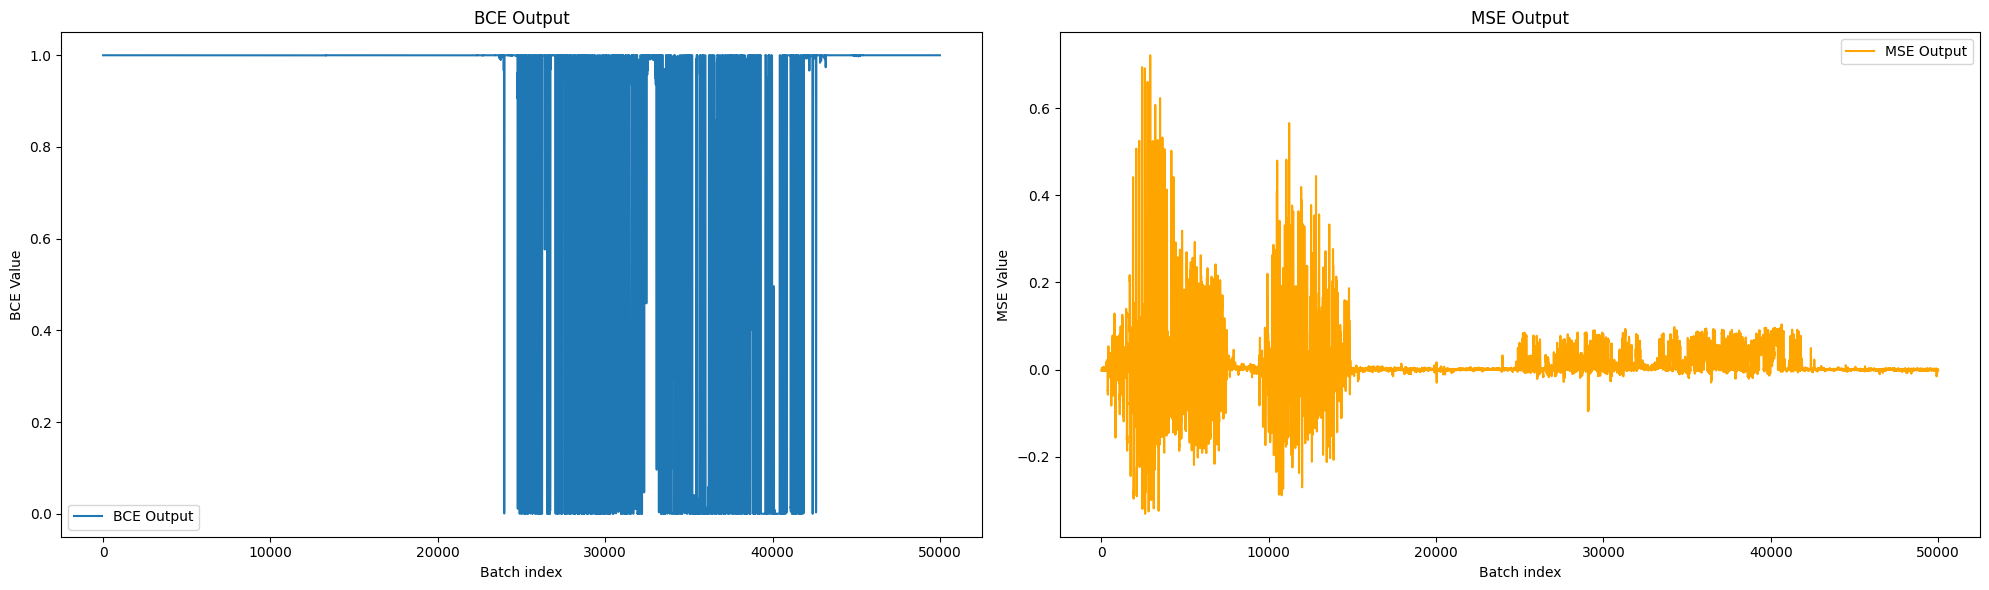

In [180]:

import matplotlib.pyplot as plt



# Create a figure and plot both outputs
plt.figure(figsize=(20, 6))

# Plot BCE outputs
plt.subplot(1, 2, 1)
plt.plot(bce_outputs.cpu().numpy(), label='BCE Output')
plt.title('BCE Output')
plt.xlabel('Batch index')
plt.ylabel('BCE Value')
plt.legend()

# Plot MSE outputs
plt.subplot(1, 2, 2)
plt.plot(mse_outputs.cpu().numpy(), label='MSE Output', color='orange')
plt.title('MSE Output')
plt.xlabel('Batch index')
plt.ylabel('MSE Value')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


In [181]:
import torch
import numpy as np
from scipy.io.wavfile import write


def tensor_to_wav(tensor, filename, sample_rate=44100,cut_off=-1 ):
    # Convert tensor to numpy array and detach if needed
    data = tensor.detach().cpu().numpy()[:cut_off]
    # Normalize to the range [-1, 1]
    #data = data / np.max(np.abs(data))

    # Convert to 16-bit PCM format (values between -32768 and 32767)
    data_int16 = np.int16(data * 32768)

    # Write the .wav file
    write(filename, sample_rate, data_int16)
    print(f"Saved as {filename}")

# Example usage with your model predictions (assuming predictions are in range -1 to 1):
# predictions is the output tensor from the model
tensor_to_wav(mse_outputs, "test_mult_first_bad.wav",sample_rate)

Saved as test_mult_first_bad.wav


In [182]:
from IPython.display import Audio

# Play the .wav file
Audio("test_mult_first_bad.wav")